In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import netCDF4
from netCDF4 import Dataset

import xarray as xr
import glob, os
#print(xr.__version__)
import xskillscore as xs

import eofs
from scipy import stats
import statsmodels.api as sm

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()

## Getting the original sea ice concentration dataset: originally from NSIDC

In [5]:
filename = '/d6/bxw2101/seaice_conc_monthly/all_seaice_conc_monthly.nc'
ds = xr.open_dataset(filename)
ds = ds.rename(time='tdim')
ds = ds.rename(xgrid='x')
ds = ds.rename(ygrid='y')

just so you know: there is stdev_of_cdf_seaice_conc_monthly variable that might be useful later!!

In [4]:
#We want to give each [x,y] combination a new lat and lon coordinate.
#The latitude/longitude file
filename = '/d6/bxw2101/seaice_conc_monthly/grid_files/NSIDC0771_LatLon_PS_S25km_v1.0.nc'
psgds = xr.open_dataset(filename)
ds = ds.assign_coords(nav_lat=psgds.latitude)
ds = ds.assign_coords(nav_lon=psgds.longitude)
sic_ds = ds
# THIS IS THE SIC DATASET WE HAVE!

In [ ]:
# We want to remove the x,y coordinates that have zero values or flagged values.
# Practically, this would work by converting the 2d xy matrix to a 1d array of (x,y) pairs.
# Then removing the (x,y) pairs whose entire rows of values = 0 or flag value.
# THEN manually performing the eof analysis. however, it would be nice if there was a function to do that automatically.
#ds_crop = ds.where((ds.cdr_seaice_conc_monthly>0) & (ds.cdr_seaice_conc_monthly < 2.51), 0, drop=True)
#ds = ds_crop
# nah this do not work.

https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates

## Building the new SIC dataset: 1longx0.5lat grid cell. regridding the xy km grid to lat,lon dimensions. 

In [15]:
# Building the new dataset takes a while. There are a bunch of lat/lon combinations to go through.
# This code takes the NEAREST

# IF WE WERE TRYING TO MAKE A 2X2, LIKE FOR THE REST OF THE VARIABLES:
# tdim: 516, Y: 20, X: 180
# lat_bins = np.arange(-88., -49, 2)
# lon_bins = np.arange(0., 359, 2)
# building_data = np.empty([20, 180, 518])
# y, x, tdim is our order of dimensions.

# now, building a 1 degree longitude by 0.5 degree latitude:
lat_bins = np.arange(-89.5, -49.5, 0.5) #Y: 80
lon_bins = np.arange(0., 360, 1) # X: 360
building_data = np.empty([80, 360, 518])
# tdim: 516, Y: 80, X: 360. So it will be 8 times as large as the 2x2 grid.

In [8]:
for lat in lat_bins:
    for lon in lon_bins:
        # First, find the index of the grid point nearest a specific lat/lon.
        
        # convert 180 to 358 to -180 to -2.
        if lon > 179.9:
            lon = lon - 360
        
        abslat = np.abs(ds.nav_lat-lat)
        abslon = np.abs(ds.nav_lon-lon)

        c = abslon**2 +  abslat**2

        (ypts, xpts) = np.where(c == np.min(c))
        yloc = ypts[0]
        xloc = xpts[0]

        # Now I can use that index location to get the values at the x/y diminsion
        point_ds = ds.isel(x=xloc, y=yloc)
        point_ds = point_ds.assign_coords({"y": lat, "x": lon})
        point_ds

        # Convert to indices of the building_data array.
#         yi = int((lat + 88) / 2)
#         xi = int(lon / 2) (these are for 2x2 grid.. we are now doing 1lonx0.5lat grid)

        yi = int((lat + 89.5) * 2)
        xi = int(lon)

        building_data[yi][xi] = point_ds.cdr_seaice_conc_monthly.values

In [10]:
times = ds.tdim.values
regridded_sic = xr.DataArray(building_data, coords=[lat_bins, lon_bins, times], dims=['y', 'x', 'tdim'])
new_ds = xr.Dataset(data_vars = {"sic": regridded_sic})
new_ds = new_ds.transpose("tdim", "y", "x")

In [11]:
new_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/new_cdr_sic_monthly_1x0p5.nc', mode='w',format='NETCDF4')
#new_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/new_cdr_sic_monthly_2x2.nc', mode='w',format='NETCDF4')

## Load the new 1longx0.5lat dataset SIC here (not anomaly yet, calculating the anomaly happens later)

In [54]:
filename = '/d6/bxw2101/combined_netcdf_files/new_cdr_sic_monthly_1x0p5.nc'
regrid_sic_ds = xr.open_dataset(filename)
# we have: 
#  - regrid_sic_ds: the new regridded, 1x0.5 lon/lat axes grid.
#        y: 80, x: 360, tdim: 518. 1978-11-01 to 2021-12-01
#        if we want to do EOF analysis, we might want to remove all x,y coords with sic = 0 or >=251.
#.       that would require us to convert to a 2d grid manually. turn the 3d 
#  - sic_ds: the OG x,y 25kmx25km grid.

In [55]:
regrid_sic_var = regrid_sic_ds.sic.where(regrid_sic_ds.sic<2.51)
sic_var = ds.cdr_seaice_conc_monthly.where(ds.cdr_seaice_conc_monthly < 2.51)
# nsidc_bt_seaice_conc_monthly is another option. but we will use cdr_seaice_conc_monthly

regrid_sic_var goes from 1978-11-01 to 2021-12-01 and has nan's for all the flagged land values.

# (Brief pause to test for correlation issues here.)

Using the regridded 1x0p5 SIC data, chop to same time series as OG paper data (1979-2000). Then save that in a separate file and run correlations on dp1.

Get the climatological mean and anomalies based on 1979-2000 and save that as another file: just like sic_anom but sic_anom_og

In [17]:
cy2004_regrid_sic_var = regrid_sic_var.isel(tdim=slice(2, 266))

cy2004_sic_mon = cy2004_regrid_sic_var.groupby('tdim.month')
cy2004_sic_clim = cy2004_sic_mon.mean(dim='tdim')
cy2004_clim_std = cy2004_sic_mon.std(dim='tdim')
cy2004_regrid_sic_anom = cy2004_sic_mon - cy2004_sic_clim
cy2004_regrid_sic_anom = cy2004_regrid_sic_anom.drop_vars('month')
# regrid_sic_anom is the one we use for 1979-2021 (defined later)
# cy2004_regrid_sic_anom is the one we use for 1979-2000

cy2004_sic_anom_ds = xr.Dataset(data_vars = {"sic_anom": cy2004_regrid_sic_anom})

cy2004_sic_anom_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/cy2004_sic_anom_monthly_1x0p5.nc', mode='w',format='NETCDF4')
#saves the cy2004_sic_anom_ds to a netcdf file, located in the above location.

## 1/6/23: To recreate the CY2004 paper as much as possible, I'm getting the 0.5latx2long grid that originally was used for CY2004, for dp1 specifically.

In [20]:
# 0.5 LAT X 2 LONG GRID BUILDING:
lat_bins = np.arange(-89.5, -49.5, 0.5) #Y: 80
lon_bins = np.arange(0., 359, 2) # X: 180
building_data = np.empty([80, 180, 518])
for lat in lat_bins:
    for lon in lon_bins:
        # First, find the index of the grid point nearest a specific lat/lon.
        
        # convert 180 to 358 to -180 to -2.
        if lon > 179.9:
            lon = lon - 360
        
        abslat = np.abs(ds.nav_lat-lat)
        abslon = np.abs(ds.nav_lon-lon)

        c = abslon**2 +  abslat**2

        (ypts, xpts) = np.where(c == np.min(c))
        yloc = ypts[0]
        xloc = xpts[0]

        # Now I can use that index location to get the values at the x/y diminsion
        point_ds = ds.isel(x=xloc, y=yloc)
        point_ds = point_ds.assign_coords({"y": lat, "x": lon})

        yi = int((lat + 89.5) * 2)
        xi = int(lon / 2)

        building_data[yi][xi] = point_ds.cdr_seaice_conc_monthly.values

In [24]:
times = ds.tdim.values
regridded_sic = xr.DataArray(building_data, coords=[lat_bins, lon_bins, times], dims=['y', 'x', 'tdim'])
new_ds = xr.Dataset(data_vars = {"sic": regridded_sic})
new_ds = new_ds.transpose("tdim", "y", "x")
new_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/cy2004_sic_monthly_2x0p5.nc', mode='w',format='NETCDF4')

### load in what should be the data that is most similar to CY2004: 0.5lat x 2long

In [45]:
filename = '/d6/bxw2101/combined_netcdf_files/cy2004_sic_monthly_2x0p5.nc'
og_sic_ds = xr.open_dataset(filename)
og_sic_var = og_sic_ds.sic.where(og_sic_ds.sic<2.51)

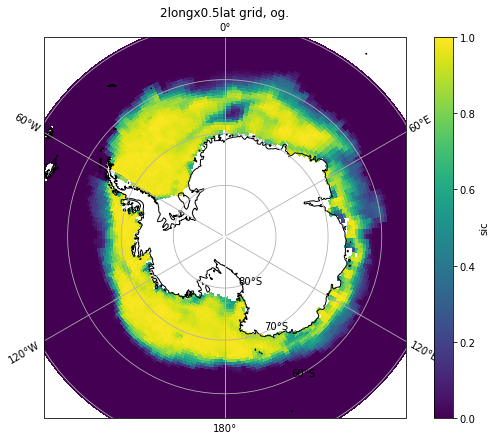

In [21]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
og_sic_var.sel(tdim='2017-11-01').plot(transform=pc) 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title('2longx0.5lat grid, og.')
plt.show()

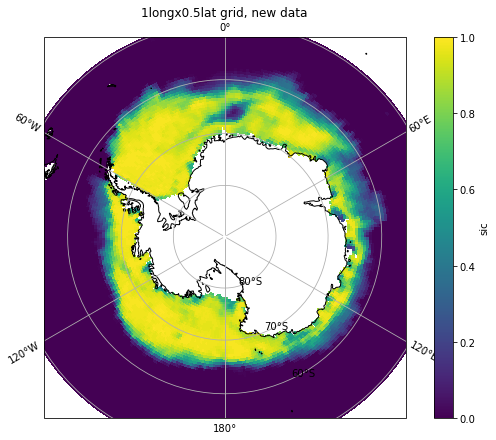

In [22]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
regrid_sic_var.sel(tdim='2017-11-01').plot(transform=pc) 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title('1longx0.5lat grid, new data')
plt.show()

### og_sic_var is now the most relevant cy2004 sic, gridded into its original 2longx0.5lat SIC variable.
As you can see, the two graphs basically show the same SIC. The resolution is just slightly diff.
### time to get the anomaly.

In [24]:
og_sic_var = og_sic_var.sel(tdim=slice('1979-01-01', '2000-12-01'))

sic_mon = og_sic_var.groupby('tdim.month')
sic_clim = sic_mon.mean(dim='tdim')
clim_std = sic_mon.std(dim='tdim')
og_sic_anom = sic_mon - sic_clim
og_sic_anom = og_sic_anom.drop_vars('month')
# og_sic_anom is the cy2004 sic anom, gridded in its og 2longx0.5lat!

og_sic_anom_ds = xr.Dataset(data_vars = {"sic_anom": og_sic_anom})

og_sic_anom_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/cy2004_sic_anom_monthly_2x0p5.nc', mode='w',format='NETCDF4')

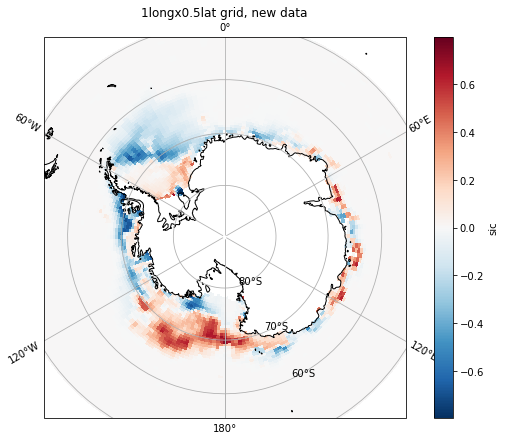

In [25]:
# JUST TESTING TO SEE IF IT WORKS (IT DOES)
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
og_sic_anom.sel(tdim='1999-01-01').plot(transform=pc) 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title('1longx0.5lat grid, new data')
plt.show()

# Plotting maps: just plotting random arbitrary times.
## This was my first time plotting SIC files, so this is a lot of testing!

In [26]:
arb_time = sic_var.sel(tdim='2017-11-01')
regrid_arb_time = regrid_sic_var.sel(tdim='2017-11-01')

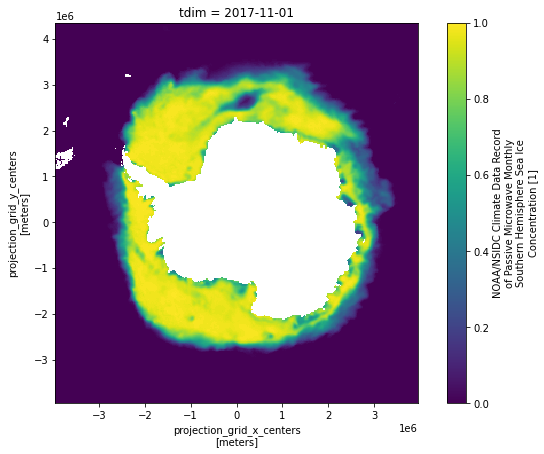

In [27]:
# Two ways to plot the original 25x25 xy km grid:
# 1. using the built in xarray .plot(). Fills in axes and does a good job.
# However it doesn't have coastlines or grid lines. So do not use this.
p1 = arb_time.plot(size=7)
p1.axes.set_aspect(1)

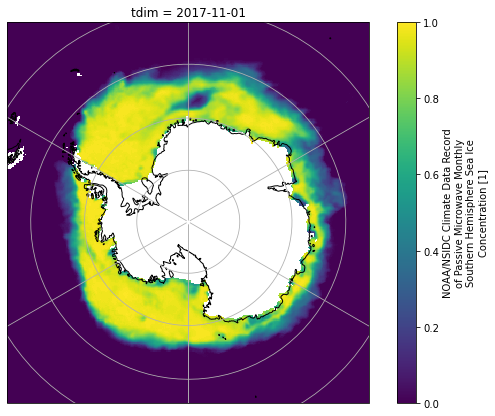

In [28]:
# 2. using .plot() with cartopy
sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()

# #ONE WAY via Cartopy
# fig = plt.figure(figsize=(10,7))
# p2 = arb_time.plot(subplot_kws=dict(projection=sp))
# ax = p2.axes
# ax.coastlines()
# ax.gridlines()
# ax.set_extent([arb_time.x[0], arb_time.x[-1], arb_time.y[-1], arb_time.y[0]], crs=sp)

#ANOTHER WAY via Cartopy. USE THIS WAY. 
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_time.plot() #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.gridlines()
ax.set_extent([arb_time.x[0], arb_time.x[-1], arb_time.y[-1], arb_time.y[0]], crs=sp)

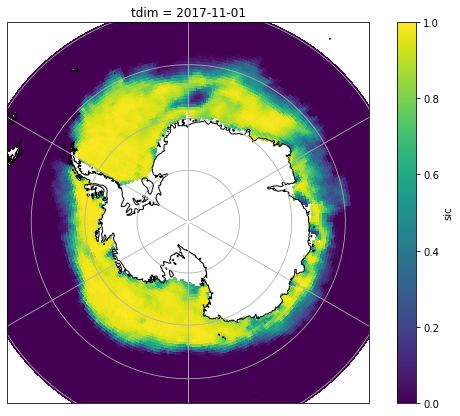

In [36]:
###_____________________________________________
# 6/29/22 UPDATE: now that we have the latitude and longitude in the og dataset, we can use those to graph.

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
regrid_arb_time.plot.pcolormesh(
    ax=ax, transform=pc, x="x", y="y",
)
ax.coastlines()
ax.gridlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
# IF we want to plot with long/lat, the map will just simply be messed up. Sad.

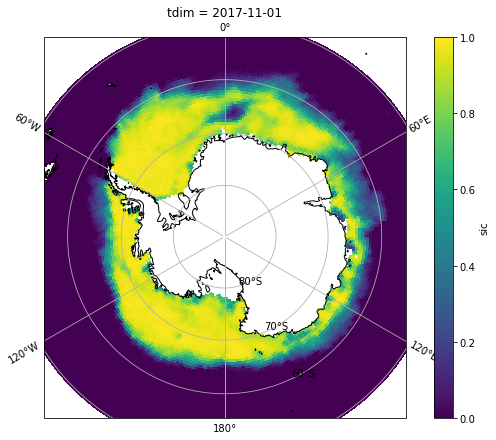

In [32]:
# Plotting the coarser resolution lat/lon grid (just like the SST plots):
# The OG Data is in pc projection, but we want to project to sp.

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
regrid_arb_time.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)


## Doing climatology stuff on the km grid og data, to get the anomalies. (Not relevant anymore for the model)

In [37]:
# CLIMATOLOGY:
sic_mon = sic_var.groupby('tdim.month')
sic_clim = sic_mon.mean(dim='tdim')
sic_anom = sic_mon - sic_clim
mean_sic_anom = sic_anom.mean(dim=['x','y'])

In [ ]:
# each point on xy grid
#moving_sic_anom = sic_anom.rolling(tdim=5, center=True).mean()
# average across entire xy grid for each month
mean_moving_sic_anom = mean_sic_anom.rolling(tdim=5, center=True).mean()
# plotting the antarctic average anomaly
mean_sic_anom.plot(size=7)
mean_moving_sic_anom.plot()
plt.legend(['anomaly', '5-month running mean anomaly'])
plt.title('SIC Anomaly over the Antarctic Region');
# You could split the overall region into separate regions...

In [ ]:
#Computing the standard deviation of the SIC in the region, over the entire time period of the data array.
std_dev = sic_var.std()
normalized_mean_moving_sic_anom = mean_moving_sic_anom / std_dev
normalized_mean_moving_sic_anom.plot(size=7)

In [ ]:
sic_clim
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
sic_clim[0].plot()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([arb_time.x[0], arb_time.x[-1], arb_time.y[-1], arb_time.y[0]], crs=sp)

In [ ]:
# Plotting all 12 month's climatologies.

#3x4 grid
fig = plt.figure(figsize=(20, 15))
for m in range(1, 13):
    mclim = sic_clim.sel(month=m)
    ax = plt.subplot(3, 4, m, projection=sp)
    mclim.plot(add_colorbar=False)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([arb_time.x[0], arb_time.x[-1], arb_time.y[-1], arb_time.y[0]], crs=sp)

# # 4x3 grid
# fig = plt.figure(figsize=(15, 20))
# for m in range(1, 13):
#     mclim = sic_clim.sel(month=m)
#     ax = plt.subplot(4, 3, m, projection=sp)
#     mclim.plot(add_colorbar=False)
#     ax.coastlines()
#     ax.gridlines()
#     ax.set_extent([arb_time.x[0], arb_time.x[-1], arb_time.y[-1], arb_time.y[0]], crs=sp)
    
fig.suptitle("Climatology for the Sea Ice Concentration in the Antarctic")

# Back to model stuff: Getting the SIC anomaly for the regridded 0.5latx1long data, and saving it to a file for later

In [ ]:
# chop regrid_sic_var into 1979-2021 by taking out nov,dec of 1978

In [57]:
chop_regrid_sic_var = regrid_sic_var.isel(tdim=slice(2, 518))
sic_mon = chop_regrid_sic_var.groupby('tdim.month')
sic_clim = sic_mon.mean(dim='tdim')
clim_std = sic_mon.std(dim='tdim')
regrid_sic_anom = sic_mon - sic_clim
regrid_sic_anom = regrid_sic_anom.drop_vars('month')
# regrid_sic_anom is the one.

sic_anom_ds = xr.Dataset(data_vars = {"sic_anom": regrid_sic_anom})
sic_anom_ds = sic_anom_ds.sel(tdim=slice('1979-01-01', '2021-12-01'))

In [59]:
sic_anom_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/sic_anom_monthly_1x0p5.nc', mode='w',format='NETCDF4')

## Saved the file to use in the model!^ Below is just testing and plots.

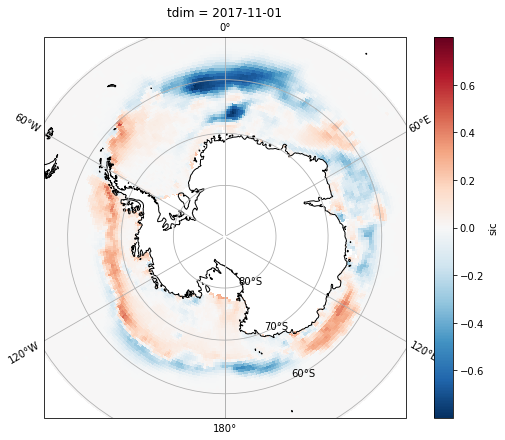

In [60]:
arb_anom = regrid_sic_anom.sel(tdim='2017-11-01')

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_anom.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

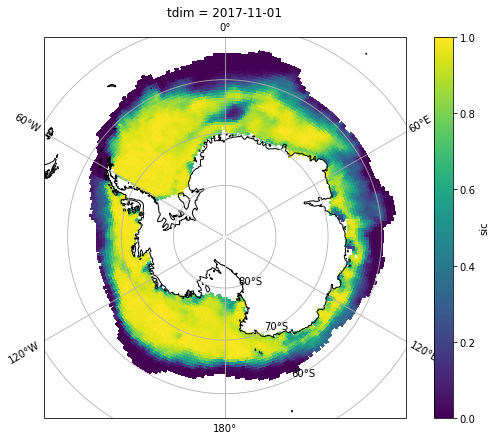

In [39]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
regrid_sic_var.where(regrid_sic_var.mean(dim='tdim')>0.05).sel(tdim='2017-11-01').plot(transform=pc) 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

## sic_anom is the dataarray for the og dataset's anomalies.

In [ ]:
# Plotting the anomaly for any month.
sic_anom
anom_month = sic_anom.sel(tdim='2017-11-01')
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
anom_month.plot()
ax.coastlines()
ax.gridlines()
ax.set_extent([arb_time.x[0], arb_time.x[-1], arb_time.y[-1], arb_time.y[0]], crs=sp)

In [ ]:
tmeans = sic_var.mean(dim='tdim')

# sic_clim.isel(x=100, y=90).plot()
# sic_clim.isel(x=100, y=100).plot()

lat_means = sic_clim.mean(dim='x')
# lat_means.transpose().plot.contourf(levels=20, cmap='turbo')

# (sic_clim.sel(month=1) - sic_clim.sel(month=12)).plot(size=7, robust = True)

# sic_anom.isel(x=100, y=90).plot()

unweighted_mean_global_anom = sic_anom.mean(dim=['x', 'y'])
# unweighted_mean_global_anom.plot()

moving_avg = sic_var.rolling(tdim=5, center=True).mean()
# moving_avg.isel(x=100, y=110).plot(size=7)
# sic_var.isel(x=100, y=110).plot()
# plt.legend(['5 month moving avg', 'monthly data'])

moving_anom = sic_anom.rolling(tdim=5, center=True).mean()
# moving_anom.isel(x=100, y=90).plot(size=7)
# sic_anom.isel(x=100, y=90).plot()
# plt.legend(['5 month moving avg @ one point', 'monthly data'])

#moving_anom.isel(x=100, y=90).plot(size=7)
#plt.title('5 month Moving Average of x=100, y=90')